In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_excel("C:\\Users\\user\\Desktop\\machine\\data_1025.xlsx",sheet_name="Sheet1")
label_encoder = LabelEncoder()

# 'fixed_type'을 숫자형으로 변환
df['fixed_type_encoded'] = label_encoder.fit_transform(df['fixed_type'])

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
df = df.drop(['sex','sc_code','age','fixed_type','ht_omr_data','FG'], axis=1)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'M': 5, 'R': 6, 'X': 7}


In [50]:
# import pandas as pd
# df = pd.read_excel("C:\\Users\\user\\Desktop\\machine\\data_1015.xlsx",sheet_name="Sheet1")
# def split_omr_data(df):
#     # 'ht_omr_data' 열의 값을 리스트로 변환 (한 글자씩)
#     omr_responses = df['ht_omr_data'].apply(lambda x: list(x[:375]))  # 480개의 문항까지만 자름
#     # 리스트를 각각의 문항으로 나누어 새로운 컬럼으로 변환
#     omr_df = pd.DataFrame(omr_responses.tolist(), columns=[f'Q{i+1}' for i in range(375)])
#     # 원래 df와 결합
#     df = pd.concat([df, omr_df], axis=1)
#     return df

# # 데이터 분리 실행
# df_split = split_omr_data(df)

# # 결과 확인
# df = df_split


In [3]:
df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t19,t20,t21,t22,t23,t24,t25,t26,t27,fixed_type_encoded
0,48,55,57,54,46,59,60,53,57,56,...,44,62,37,49,53,51,46,39,61,0
1,61,56,61,60,50,57,55,53,54,44,...,42,41,30,39,43,54,44,57,41,2
2,46,36,51,52,46,52,49,49,57,48,...,43,55,47,44,44,48,45,43,65,5
3,46,54,46,61,48,59,52,61,64,60,...,44,41,36,46,44,40,46,41,57,5
4,37,39,46,50,44,57,64,55,56,59,...,42,45,46,42,43,42,44,41,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30866,44,51,51,56,58,57,49,47,49,51,...,43,41,41,44,51,53,45,58,53,0
30867,43,53,43,49,43,46,45,52,47,53,...,52,80,60,55,60,45,57,47,38,5
30868,45,35,53,42,44,45,54,54,56,51,...,51,47,64,52,43,41,43,40,39,0
30869,43,51,50,44,51,52,49,56,58,47,...,45,41,40,50,42,50,46,42,45,0


In [89]:
df.columns

Index(['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11',
       't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21',
       't22', 't23', 't24', 't25', 't26', 't27', 'fixed_type_encoded'],
      dtype='object')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb

from sklearn.model_selection import train_test_split

In [14]:
X = df.iloc[:,:-1]

y = df['fixed_type_encoded']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000, stratify=y)

In [47]:
dtrain = xgb.DMatrix(data = x_train, label = y_train)
dtest = xgb.DMatrix(data = x_test, label = y_test)

model_path = 'C:\\Users\\user\\Desktop\\best_xgb_model_class7.json'

In [59]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV
import numpy as np



# 하이퍼파라미터 그리드
param_dist = {
    "max_depth": [4, 6, 8, 10],
    "eta": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "gamma": [0, 1, 5],
    "num_class": [8],
    "objective": ["multi:softmax"],
    "eval_metric": ["merror"]
}

# XGBoost 모델 초기화
xgb_clf = xgb.XGBClassifier(use_label_encoder=False)

# 랜덤 그리드 서치 설정
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,  # 테스트할 파라미터 조합 수
    scoring='accuracy',
    cv=5,  # 5-fold 교차 검증
    verbose=1,
    random_state=1000,
    n_jobs=-1
)

# 랜덤 그리드 서치 수행
random_search.fit(x_train, y_train)

# 최적 파라미터와 성능 출력
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# 최적 파라미터로 최종 모델 학습
best_params = random_search.best_params_
xgb_model = xgb.train(
    params=best_params, 
    dtrain=xgb.DMatrix(x_train, label=y_train),
    num_boost_round=num_rounds,
    evals=[(xgb.DMatrix(x_train, label=y_train), "train"), (xgb.DMatrix(x_test, label=y_test), "eval")],
    early_stopping_rounds=25
)
xgb_model.save_model(model_path)  # 모델을 파일로 저장
# 모델 성능 평가
y_pred = xgb_model.predict(xgb.DMatrix(x_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

# ROC AUC 계산
y_test_binarized = label_binarize(y_test, classes=range(8))
y_pred_binarized = label_binarize(y_pred, classes=range(8))
roc_auc = roc_auc_score(y_test_binarized, y_pred_binarized, average='weighted')
print(f"ROC AUC: {roc_auc:.5f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'objective': 'multi:softmax', 'num_class': 8, 'max_depth': 10, 'gamma': 0, 'eval_metric': 'merror', 'eta': 0.1, 'colsample_bytree': 0.8}
Best Accuracy: 0.9395447290957784
[0]	train-merror:0.10034	eval-merror:0.13619
[1]	train-merror:0.08439	eval-merror:0.12016
[2]	train-merror:0.06754	eval-merror:0.10688
[3]	train-merror:0.06284	eval-merror:0.10267
[4]	train-merror:0.05819	eval-merror:0.09781
[5]	train-merror:0.05373	eval-merror:0.09393
[6]	train-merror:0.05224	eval-merror:0.09215
[7]	train-merror:0.04932	eval-merror:0.09053
[8]	train-merror:0.04742	eval-merror:0.08761
[9]	train-merror:0.04636	eval-merror:0.08745
[10]	train-merror:0.04474	eval-merror:0.08583
[11]	train-merror:0.04276	eval-merror:0.08632
[12]	train-merror:0.04183	eval-merror:0.08470
[13]	train-merror:0.04114	eval-merror:0.08340
[14]	train-merror:0.04130	eval-merror:0.08405
[15]	train-merror:0.03944	eval-merror:0.08291
[16]	train-merror:0.03822	eval-merror:0.08243
[17]	train-merror:0.0

In [60]:
loaded_model = xgb.Booster()
loaded_model.load_model(model_path)

Accuracy: 0.9362


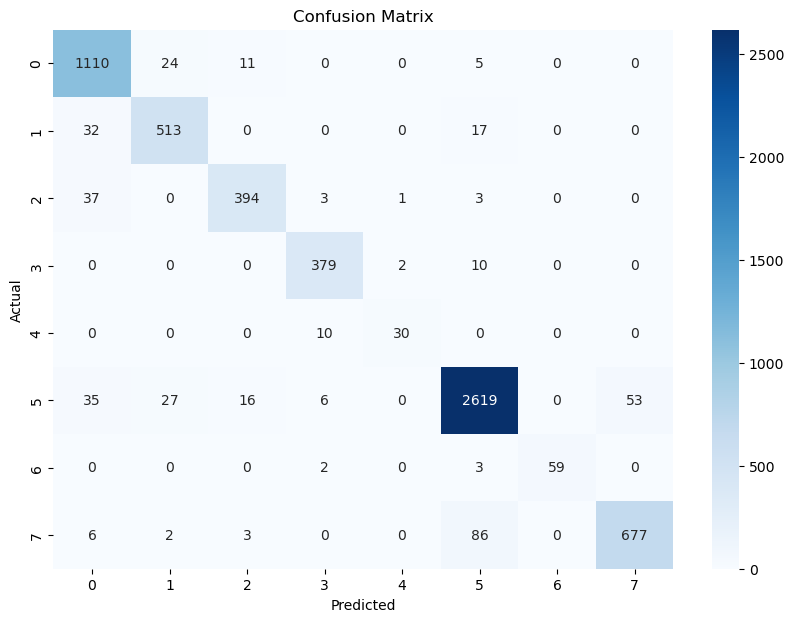

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1150
           1       0.91      0.91      0.91       562
           2       0.93      0.90      0.91       438
           3       0.95      0.97      0.96       391
           4       0.91      0.75      0.82        40
           5       0.95      0.95      0.95      2756
           6       1.00      0.92      0.96        64
           7       0.93      0.87      0.90       774

    accuracy                           0.94      6175
   macro avg       0.94      0.91      0.92      6175
weighted avg       0.94      0.94      0.94      6175

Balanced Accuracy: 0.9055
F1-Score (weighted): 0.9360
Precision (weighted): 0.9365
Recall (weighted): 0.9362
ROC-AUC (weighted, OVR): 0.9566
Cohen's Kappa: 0.9129
Matthews Correlation Coefficient (MCC): 0.9130


In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 테스트 데이터에 대한 예측 (확률이 아닌 레이블을 반환)
y_pred = loaded_model.predict(dtest).astype(int)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report (Precision, Recall, F1-Score 포함)
class_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", class_report)

# Balanced Accuracy (클래스 불균형 문제 해결을 위한 정확도)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score (weighted): {f1:.4f}")

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (weighted): {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (weighted): {recall:.4f}")

# ROC-AUC는 다중 클래스 분류에서 각 클래스별로 계산
num_classes = 8  # 전체 클래스 수
y_test_onehot = np.eye(num_classes)[y_test]  # y에 대해 one-hot encoding
y_pred_onehot = np.eye(num_classes)[y_pred]  # y_pred에 대해 one-hot encoding

# ROC-AUC 계산 (One-vs-Rest 방식으로 다중 클래스에 대한 ROC-AUC 계산)
roc_auc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr', average='weighted')
print(f"ROC-AUC (weighted, OVR): {roc_auc:.4f}")

# Cohen's Kappa 계산
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {cohen_kappa:.4f}")

# Matthews Correlation Coefficient (MCC) 계산
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예측된 클래스 (y_pred)와 테스트 데이터에서 T-점수를 결합합니다.
# x_test는 t1 ~ t27의 값을 포함하고 있으므로, x_test와 y_pred를 결합합니다.
df_test = x_test.copy()  # x_test를 복사
df_test['Predicted_Class'] = y_pred  # 예측된 클래스를 새로운 열로 추가

# # T-점수 열 이름 (t1 ~ t27) 목록 생성
# t_score_cols = [f't{i}' for i in range(1, 28)]

# # 예시로 t1에 대해 박스플롯을 그려서 예측된 클래스별 T-점수 분포 시각화
# for n in range(1,28):
#     plt.figure(figsize=(12, 8))
#     sns.boxplot(x='Predicted_Class', y=f't{n}', data=df_test)
#     plt.title(f'pred_class in t{n} score')
#     plt.xlabel('pred_class')
#     plt.ylabel(f't{n} score')
#     plt.show()

t_score_cols = [f't{i}' for i in range(1, 28)]

# 예측된 클래스에 따라 T-점수별 요약 통계 계산 (describe 함수로 요약)
summary_df = df_test.groupby('Predicted_Class')[t_score_cols].describe().T

# 결과를 확인할 수 있도록 출력
print(summary_df)


Predicted_Class            0           1           2           3         4  \
t1  count        1220.000000  566.000000  424.000000  400.000000  33.00000   
    mean           50.444262   40.644876   59.308962   44.045000  35.30303   
    std             5.839893    5.546524    4.399260   11.375918  10.24538   
    min            32.000000   26.000000   44.000000   19.000000  15.00000   
    25%            46.000000   37.000000   57.000000   35.000000  29.00000   
...                      ...         ...         ...         ...       ...   
t27 min            34.000000   34.000000   34.000000   35.000000  44.00000   
    25%            41.000000   41.000000   40.000000   53.000000  59.00000   
    50%            46.000000   47.000000   44.500000   59.000000  72.00000   
    75%            53.000000   54.000000   50.000000   67.000000  73.00000   
    max            73.000000   80.000000   66.000000   80.000000  80.00000   

Predicted_Class            5          6           7  
t1  count

In [63]:
summary_df.to_excel("C:\\Users\\user\\Desktop\\중간확인용2_class7.xlsx")

In [64]:
df_test.to_excel("C:\\Users\\user\\Desktop\\중간확인용_class8.xlsx")

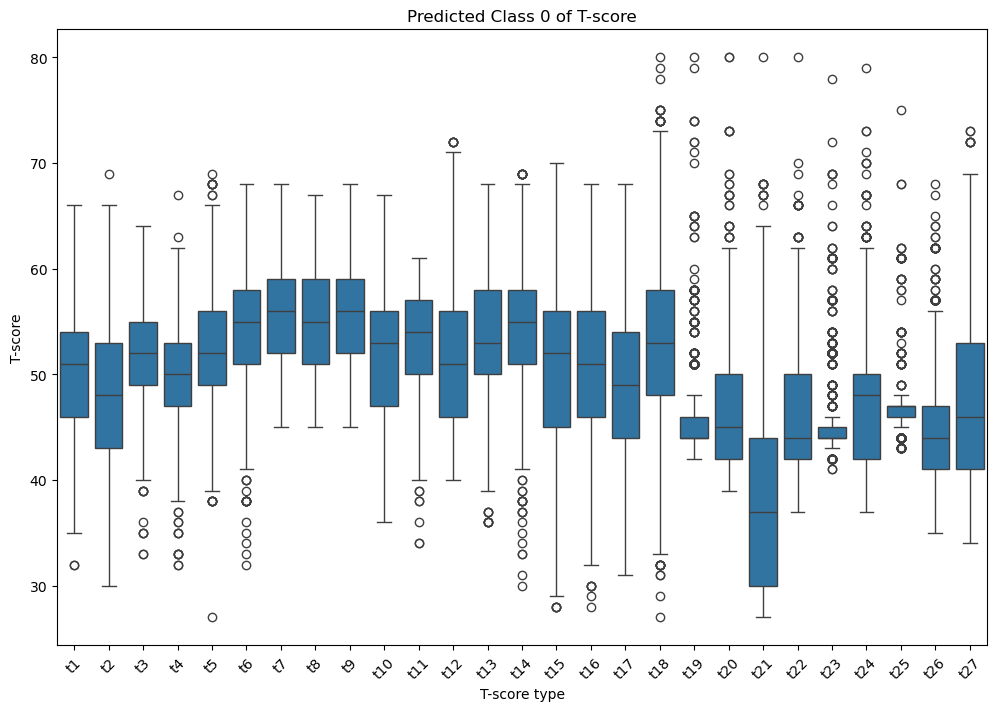

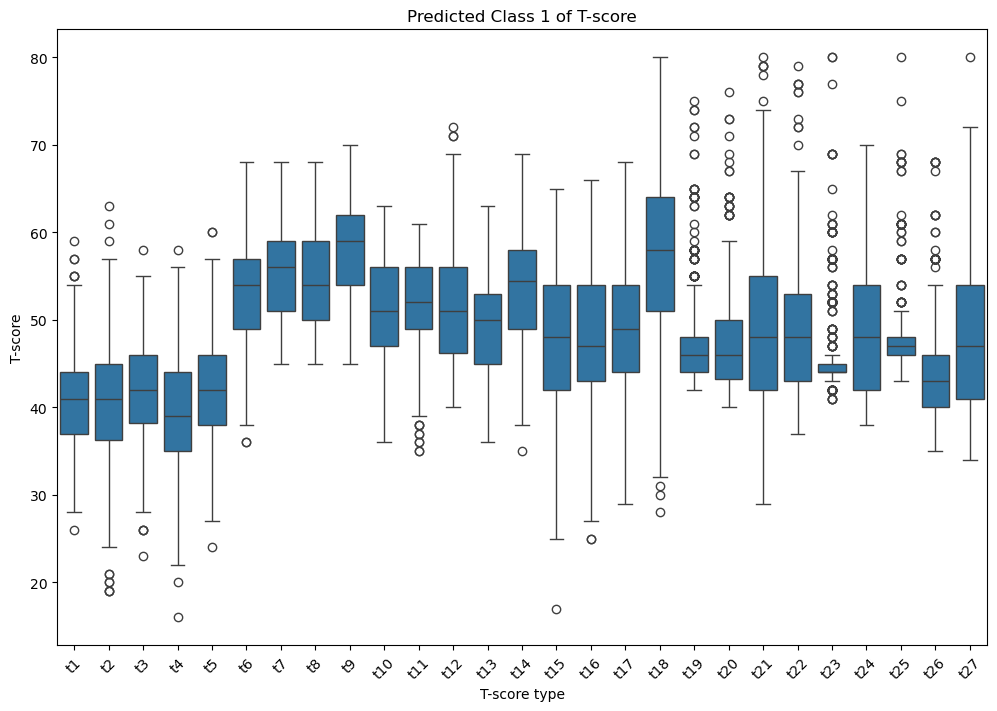

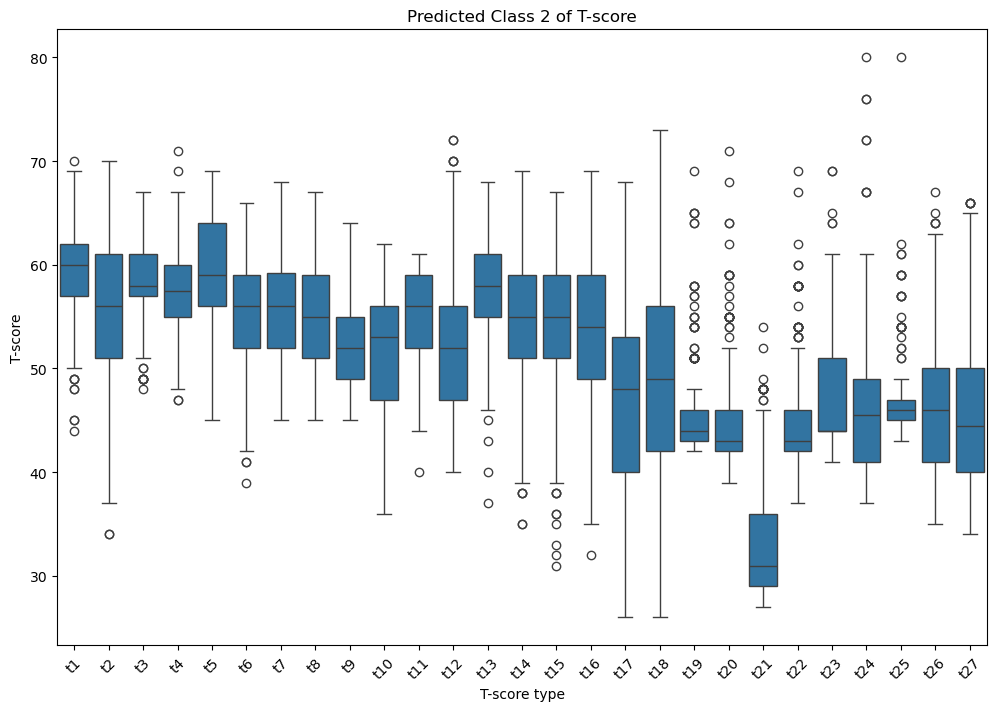

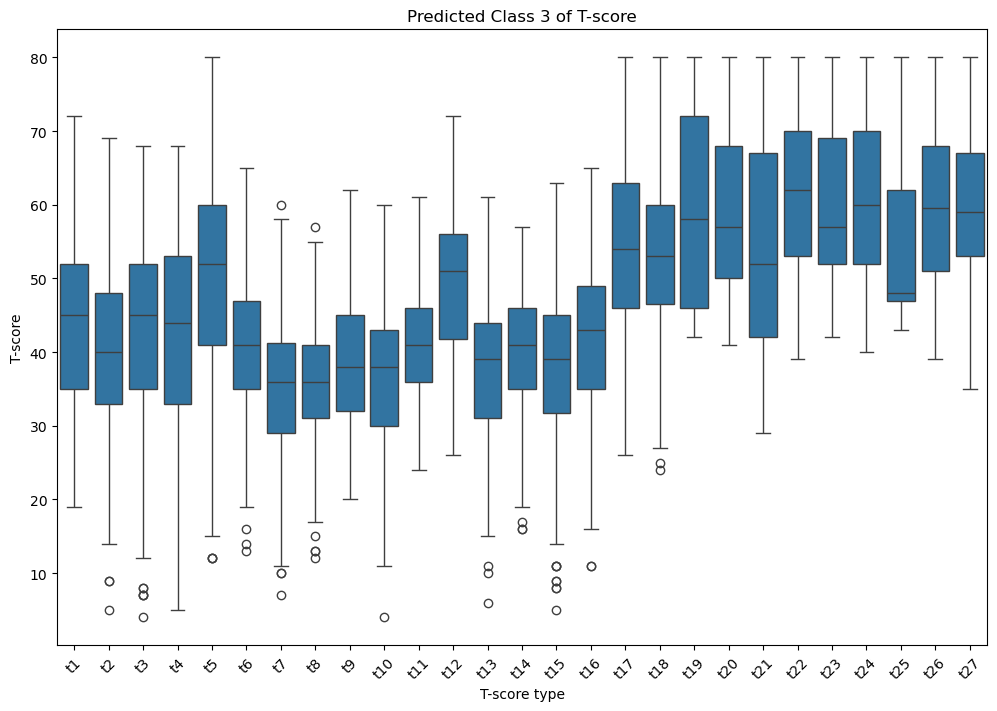

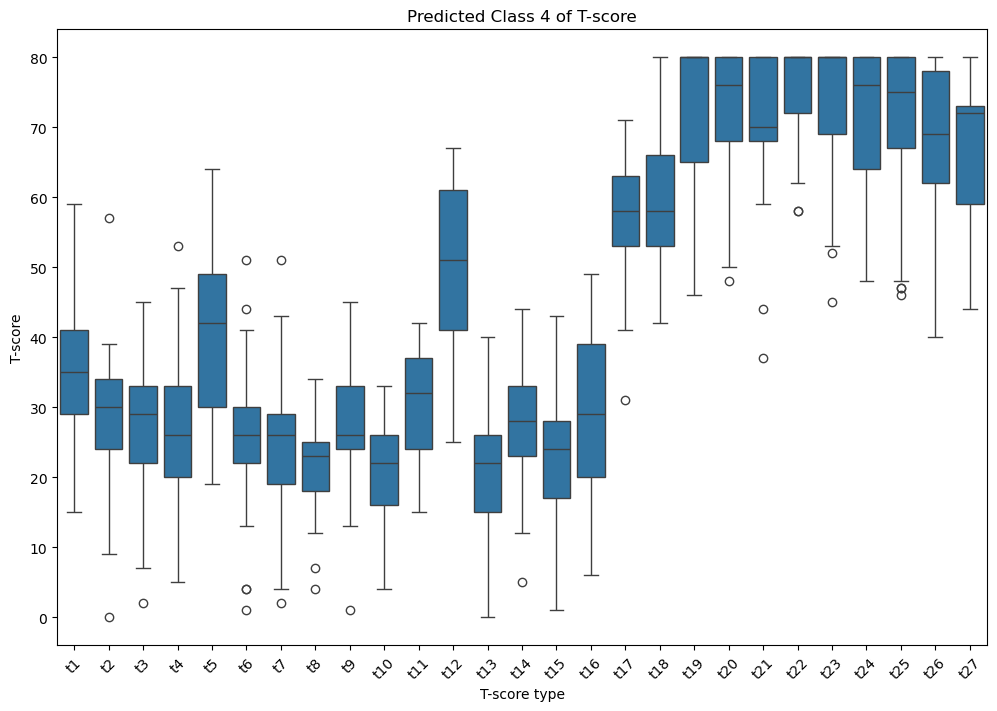

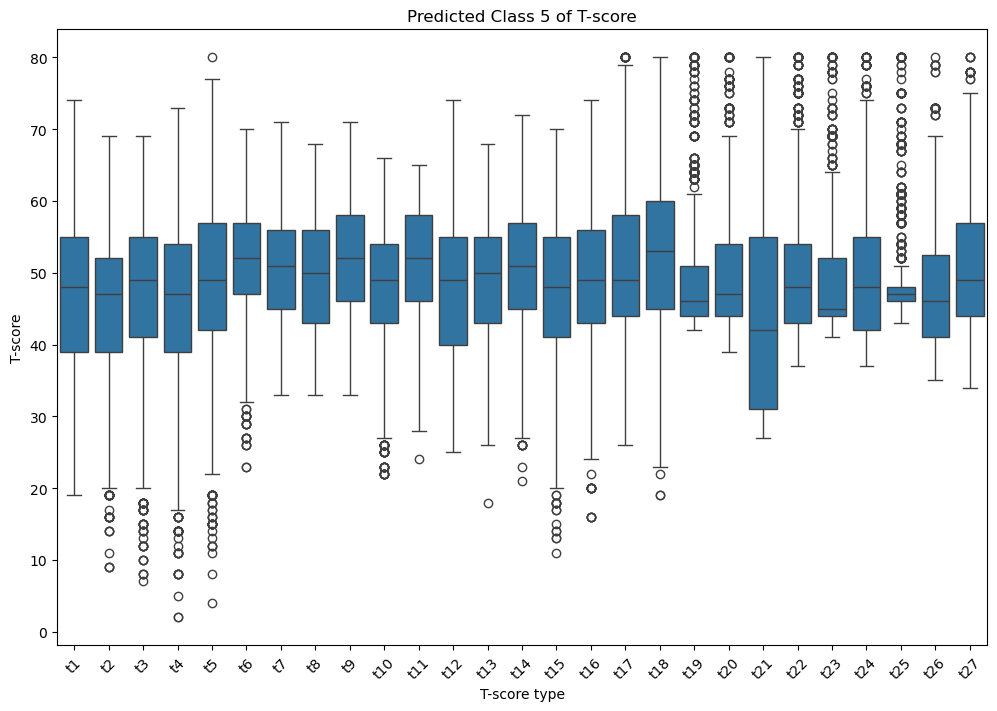

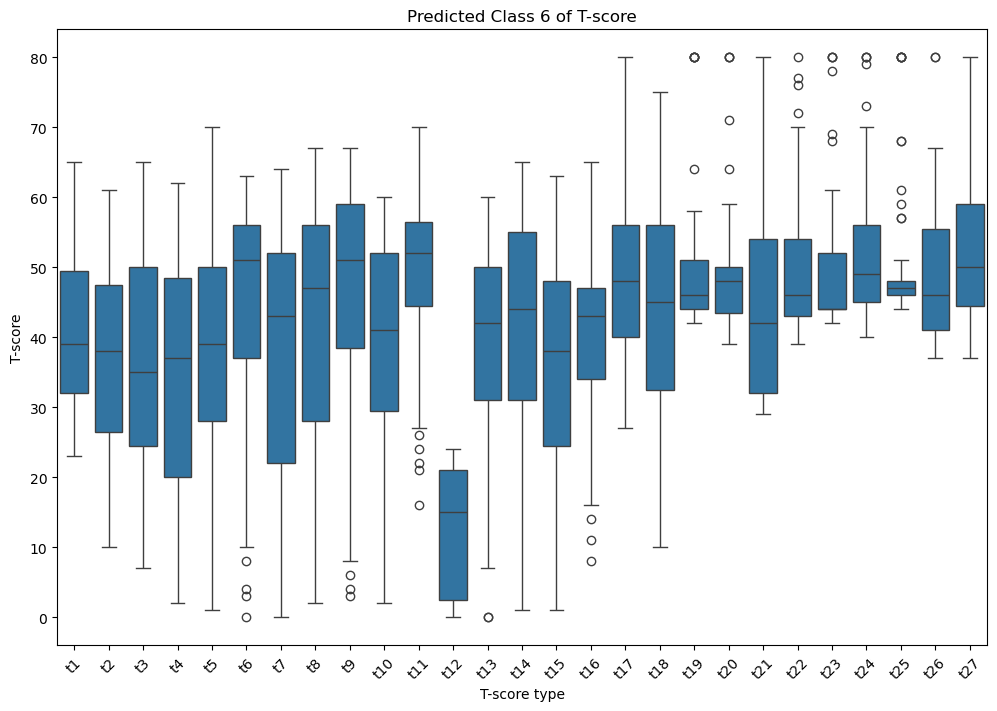

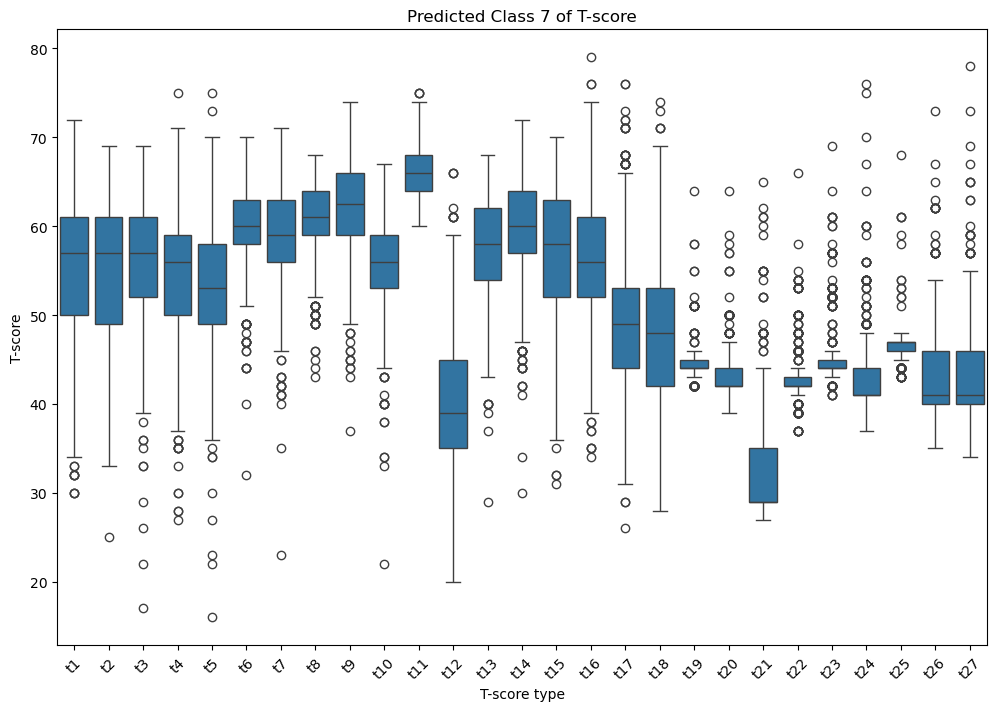

Class 8에 대한 데이터가 없습니다.
Class 9에 대한 데이터가 없습니다.
Class 10에 대한 데이터가 없습니다.
Class 11에 대한 데이터가 없습니다.
Class 12에 대한 데이터가 없습니다.
Class 13에 대한 데이터가 없습니다.
Class 14에 대한 데이터가 없습니다.


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예측된 클래스와 T-점수 데이터를 결합 (x_test는 t1~t27 열 포함)
df_test = x_test.copy()
df_test['Predicted_Class'] = y_pred
# T-점수 열 목록 (t1 ~ t27)
t_score_cols = [f't{i}' for i in range(1, 28)]

# 0부터 14까지 모든 클래스에 대해 플롯 생성
for pred_class in range(15):  # 0부터 14까지 반복
    plt.figure(figsize=(12, 8))
    
    # 해당 클래스에 대한 데이터만 필터링
    class_data = df_test[df_test['Predicted_Class'] == pred_class]
    
    # 데이터가 없는 클래스는 빈 데이터프레임으로 처리
    if class_data.empty:
        print(f"Class {pred_class}에 대한 데이터가 없습니다.")
        continue
    
    # melt 함수를 사용하여 t1~t27 열을 긴 형식으로 변환
    class_data_melted = class_data.melt(value_vars=t_score_cols, var_name='T_Score_Type', value_name='T_Score')
    
    # 박스플롯 그리기
    sns.boxplot(x='T_Score_Type', y='T_Score', data=class_data_melted)
    plt.title(f'Predicted Class {pred_class} of T-score')
    plt.xlabel('T-score type')
    plt.ylabel('T-score')
    plt.xticks(rotation=45)
    
    # 플롯 저장 (파일명에 클래스 정보를 포함)
    plt.savefig(f'C:\\Users\\user\\Desktop\\pic\\pred_class_{pred_class}_t_score_distribution.png')
    
    # 화면에 표시
    plt.show()


In [29]:
print("예측된 클래스 목록:", df_test['Predicted_Class'].unique())
print("실제 클래스 목록:", y_test.unique())


예측된 클래스 목록: [14  7  3  0  1 13  2  6  8]
실제 클래스 목록: [14  7  5  0  3  1 13  2  6  8  4 10  9 12 11]


<Figure size 800x1000 with 0 Axes>

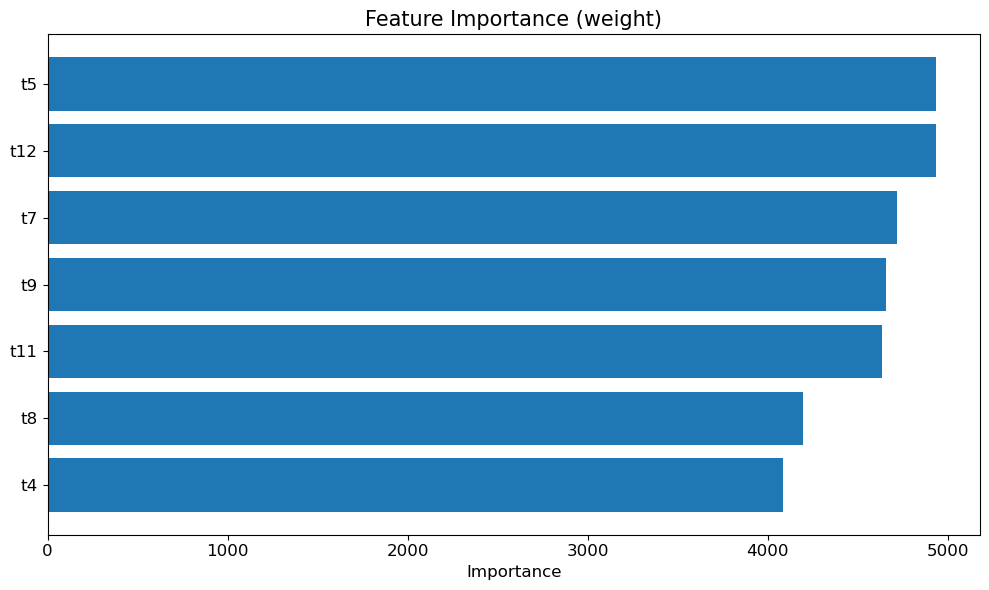

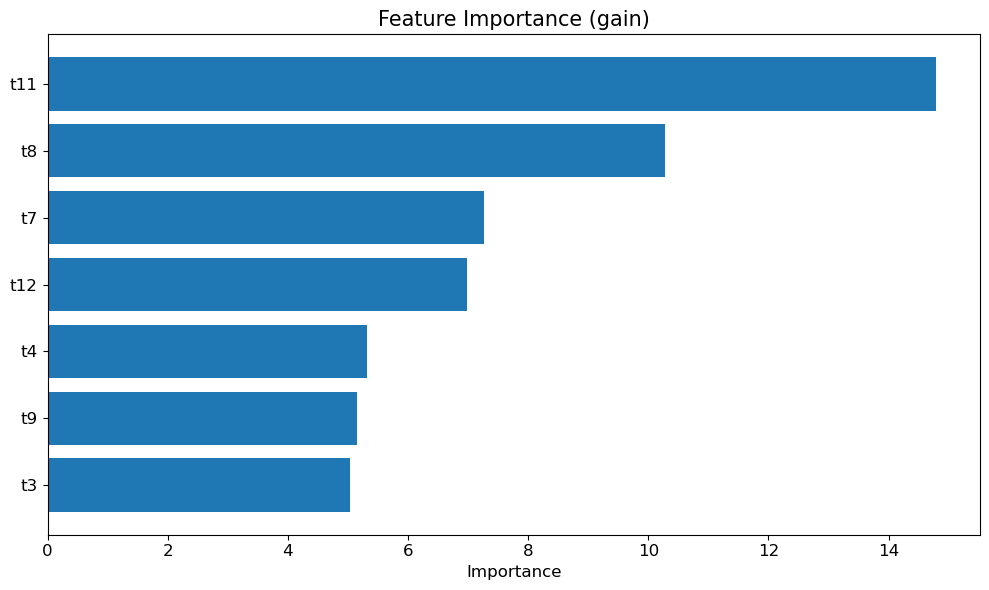

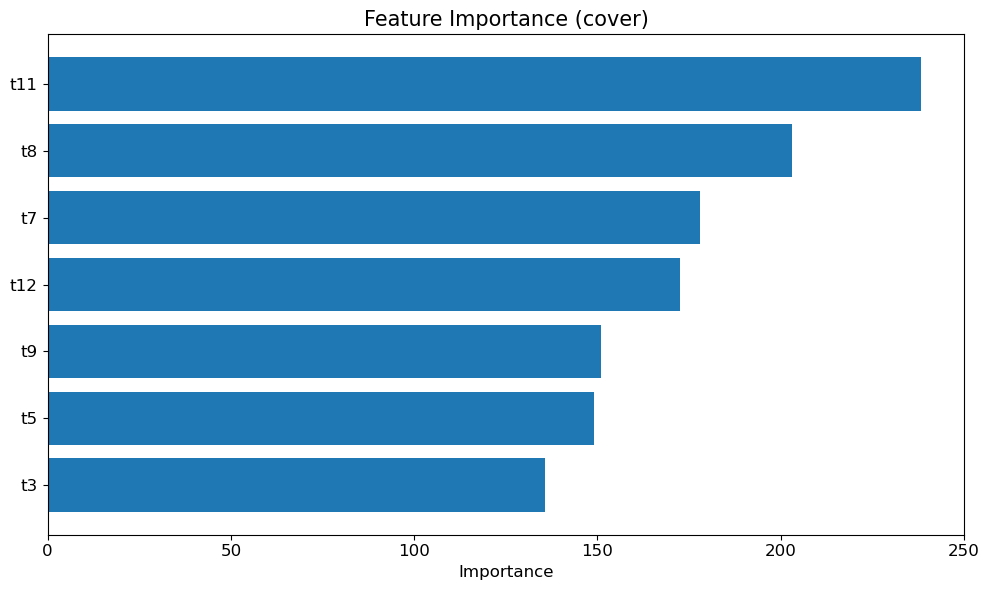

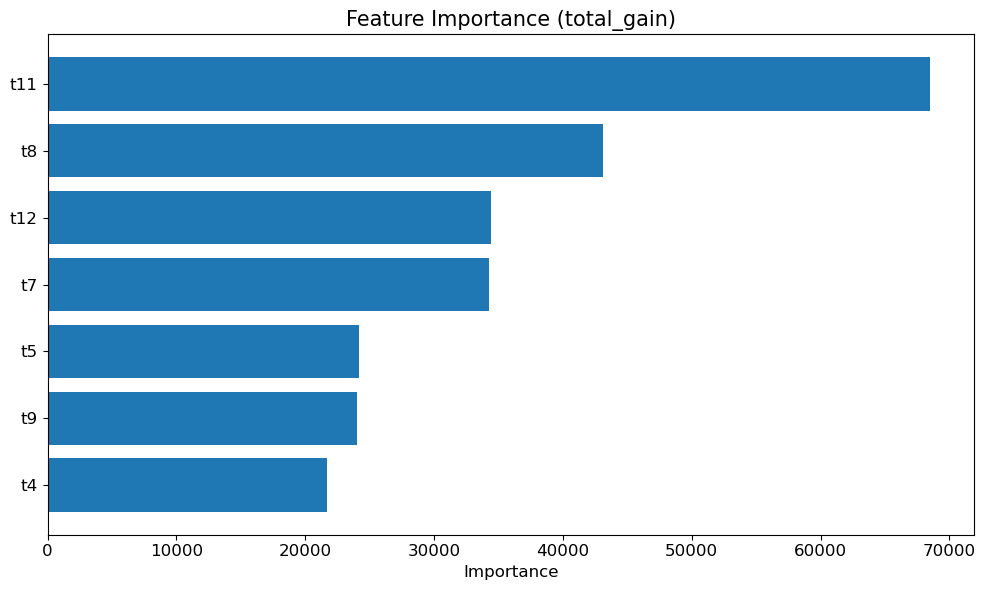

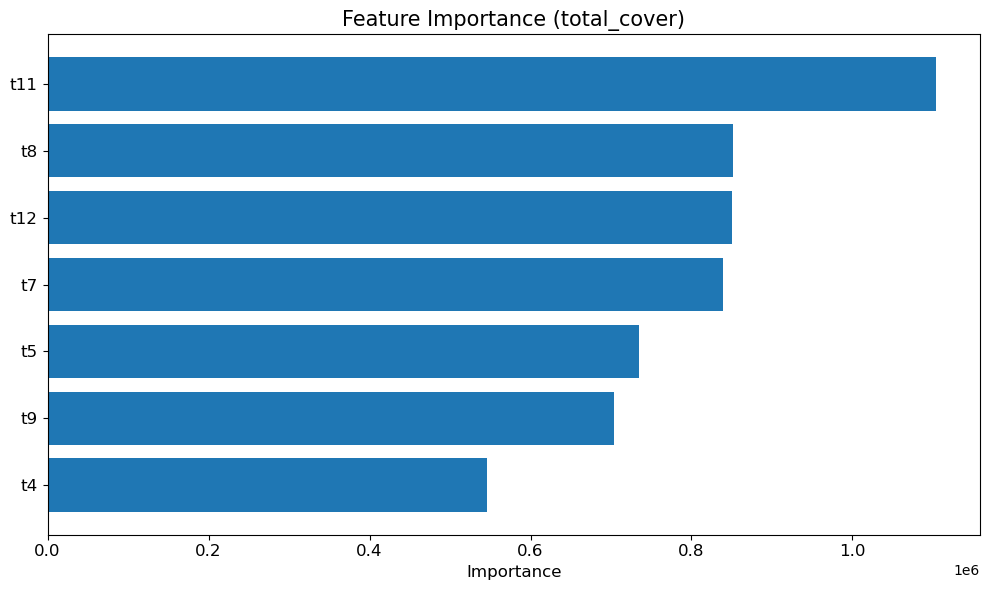

In [66]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np

# 플롯 크기를 설정하여 가독성을 높입니다.
plt.figure(figsize=(8, 10))  # 세로 길이를 크게 설정하여 피처들을 더 잘 보이게

# 상위 N개의 피처만 선택할 수 있는 기능 추가
top_n = 7  # 상위 7개의 피처만 선택

for i in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
    importance_type = i

    # 중요도 추출
    importance_dict = loaded_model.get_score(importance_type=importance_type)

    # 중요도 상위 7개만 선택하여 정렬
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # 상위 7개의 피처 이름과 중요도 값 분리
    labels, values = zip(*sorted_importance)
    indices = np.arange(len(labels))

    # 플롯 그리기
    plt.figure(figsize=(10, 6))  # 플롯 크기 설정
    plt.barh(indices, values, align='center')
    plt.yticks(indices, labels, fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f"Feature Importance ({importance_type})", fontsize=15)

    plt.gca().invert_yaxis()  # y축을 역순으로 표시 (중요도가 높은 순서대로)
    plt.tight_layout()  # 레이아웃 자동 조정
    plt.show()


Training model for class 0 vs rest
Training model for class 1 vs rest
Training model for class 2 vs rest
Training model for class 3 vs rest
Training model for class 4 vs rest
Training model for class 5 vs rest
Training model for class 6 vs rest
Training model for class 7 vs rest
Training model for class 8 vs rest
Training model for class 9 vs rest
Training model for class 10 vs rest
Training model for class 11 vs rest
Training model for class 12 vs rest
Training model for class 13 vs rest
Training model for class 14 vs rest


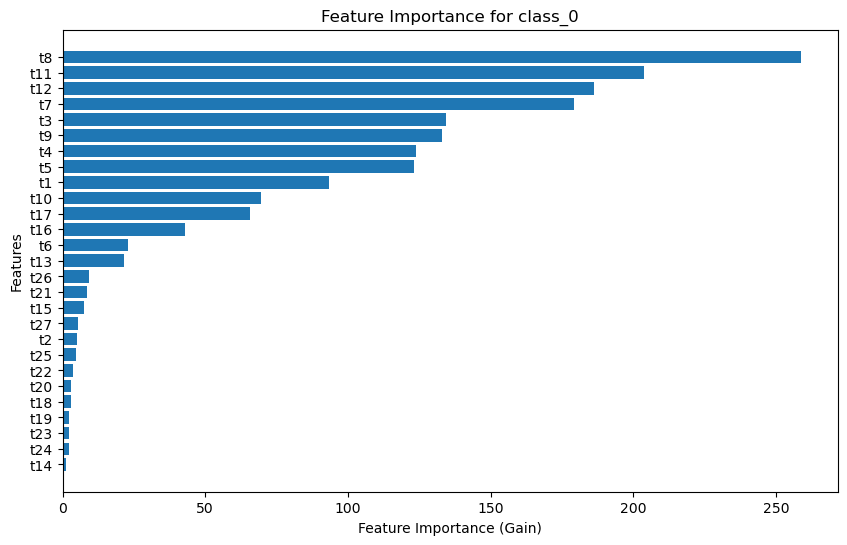

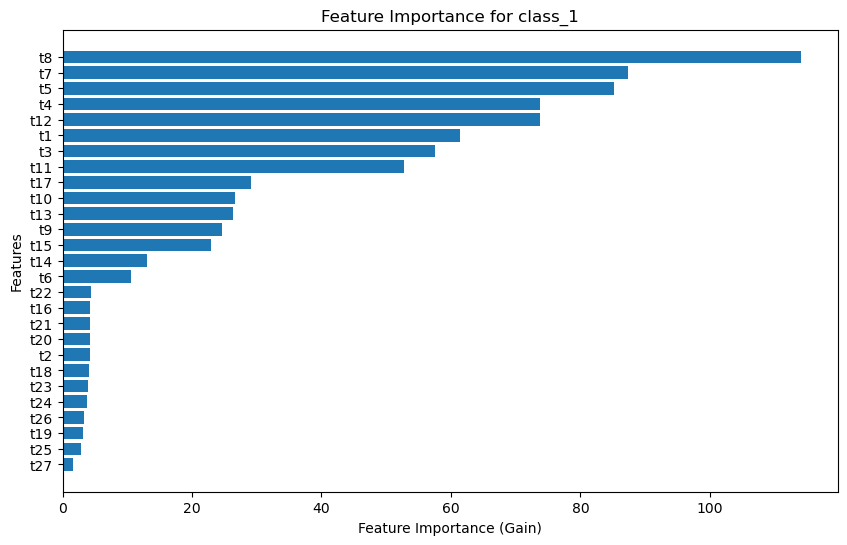

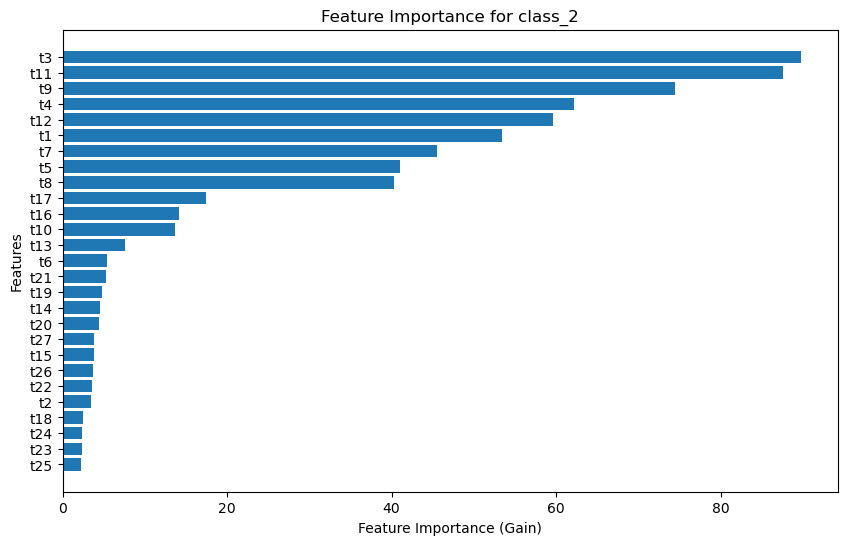

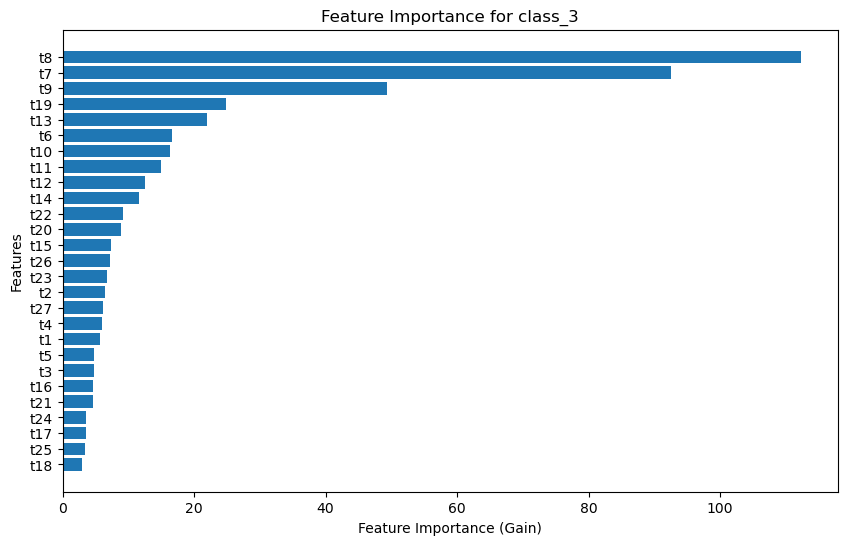

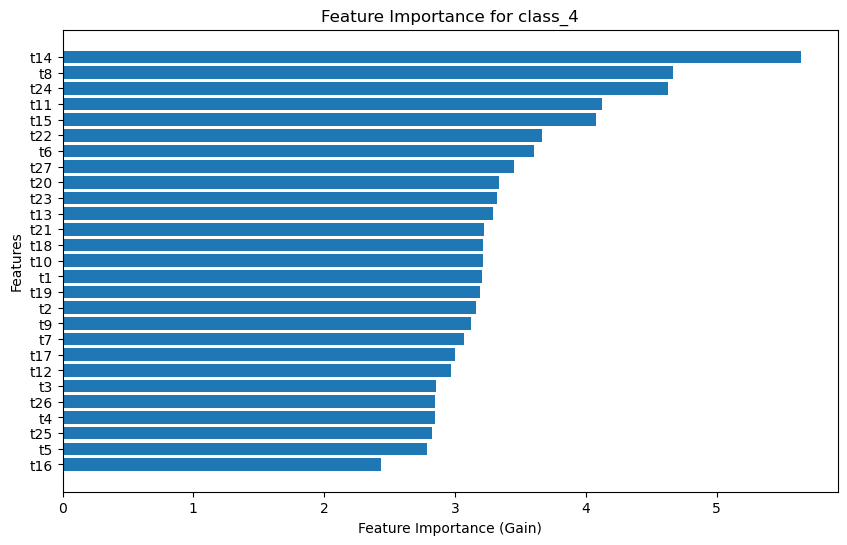

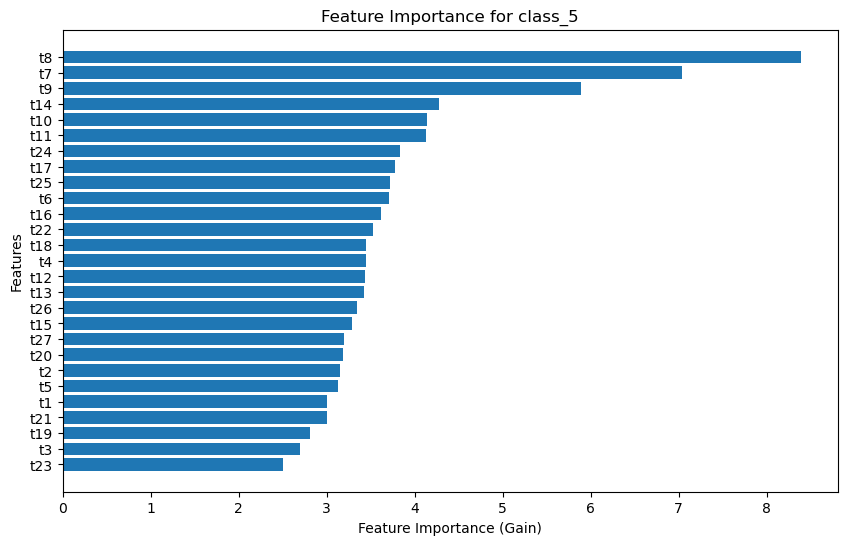

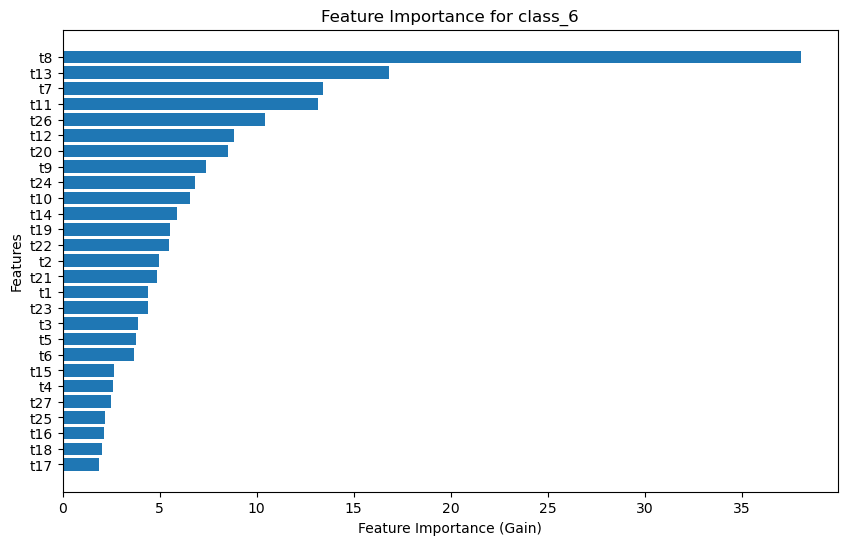

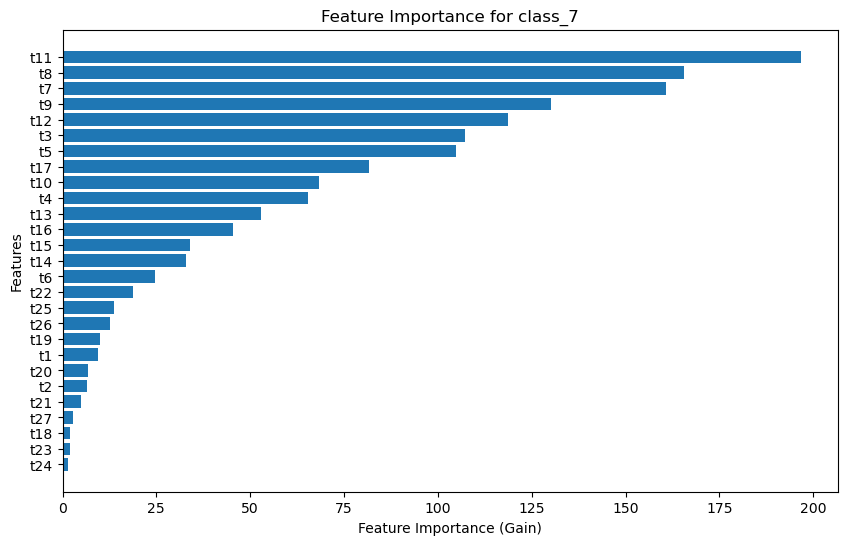

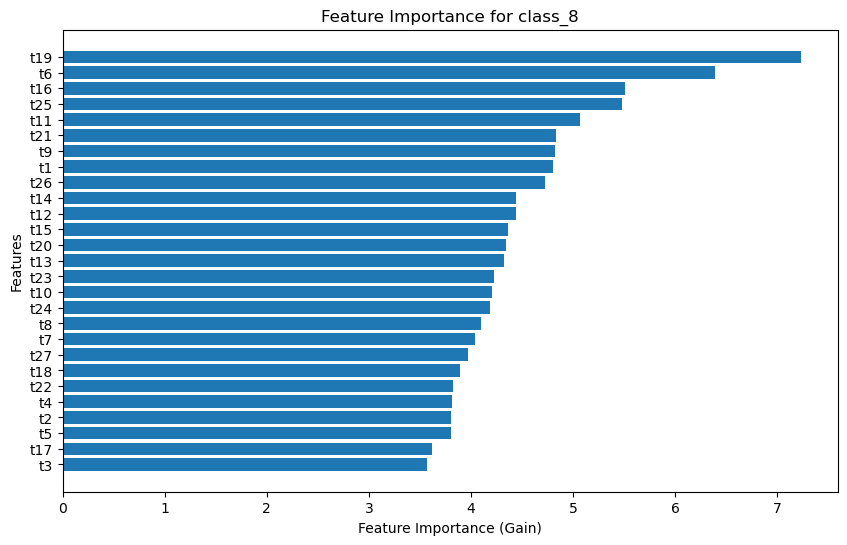

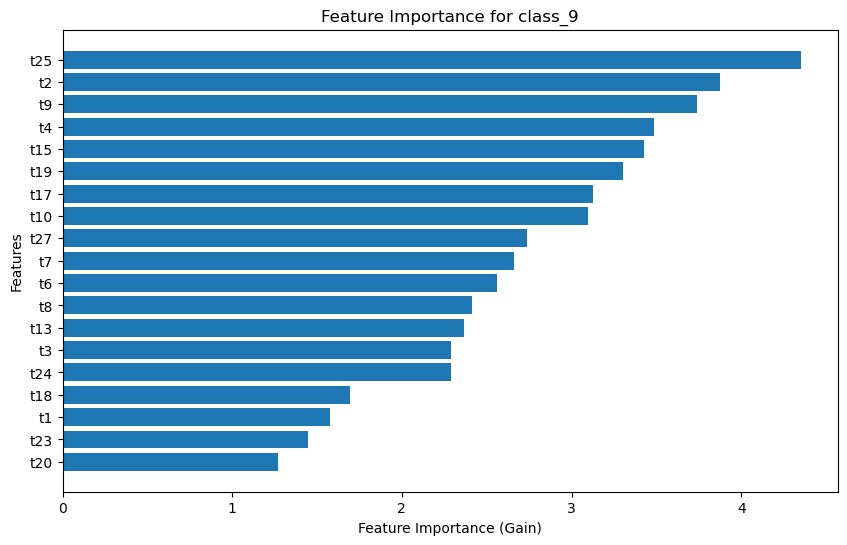

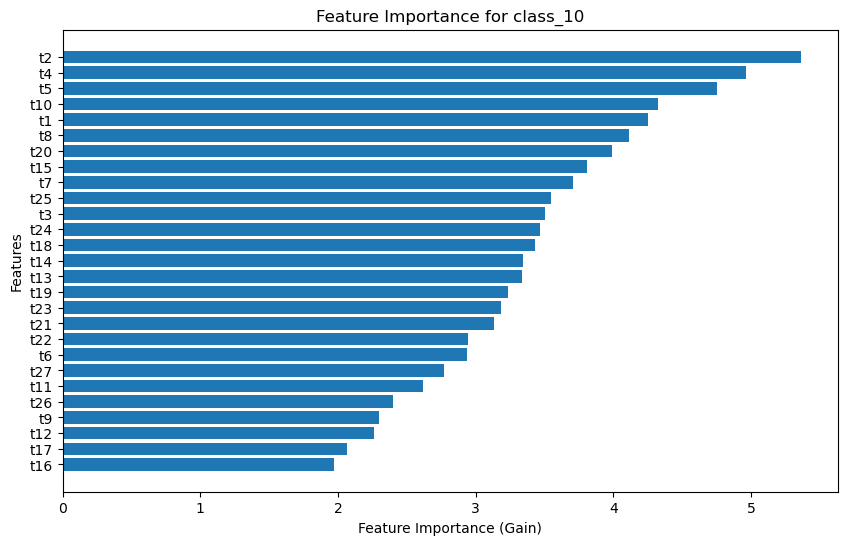

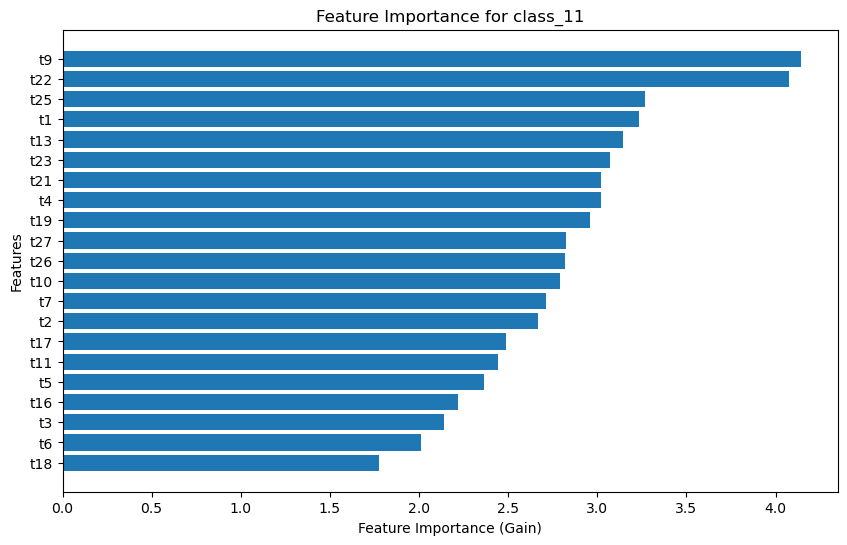

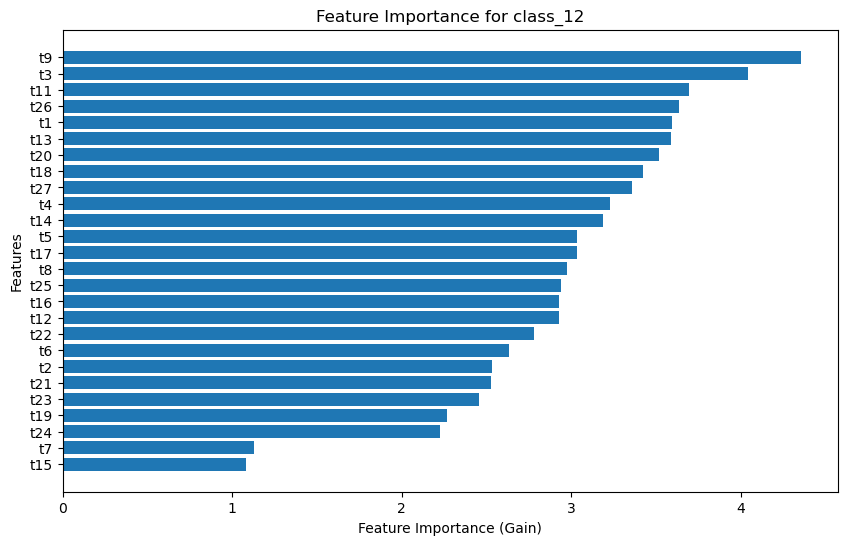

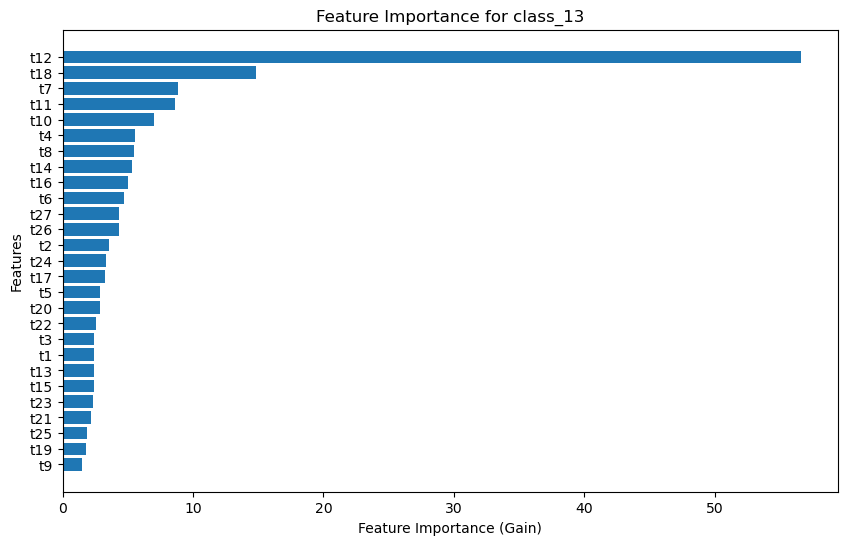

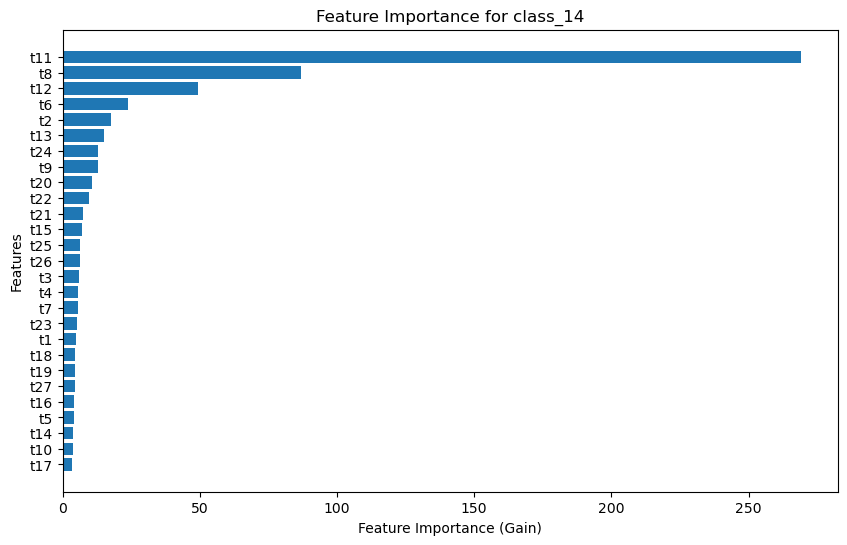

In [159]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

# 클래스 수 설정
num_classes = 15

# 각 클래스를 대상으로 이진 분류 모델을 학습하여 중요도를 저장
feature_importances_by_class = {}

for class_idx in range(num_classes):
    print(f"Training model for class {class_idx} vs rest")
    
    # 현재 클래스와 나머지 클래스를 이진 분류로 설정
    y_train_binary = (y_train == class_idx).astype(int)
    y_test_binary = (y_test == class_idx).astype(int)
    
    # DMatrix 생성
    dtrain_binary = xgb.DMatrix(x_train, label=y_train_binary)
    dtest_binary = xgb.DMatrix(x_test, label=y_test_binary)
    
    # 이진 분류 모델 학습
    params_binary = {
        "max_depth": 4,
        "eta": 0.05,
        "objective": "binary:logistic",  # 이진 분류로 설정
        "eval_metric": "logloss",
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "gamma": 1
    }
    model_binary = xgb.train(params=params_binary, dtrain=dtrain_binary, num_boost_round=150)
    
    # 현재 클래스에 대한 피처 중요도 추출
    class_importances = model_binary.get_score(importance_type="gain")
    feature_importances_by_class[f'class_{class_idx}'] = class_importances

# 각 클래스별 중요도 시각화
for class_name, importance in feature_importances_by_class.items():
    sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_importance.keys()), list(sorted_importance.values()))
    plt.xlabel("Feature Importance (Gain)")
    plt.ylabel("Features")
    plt.title(f"Feature Importance for {class_name}")
    plt.gca().invert_yaxis()
    plt.show()


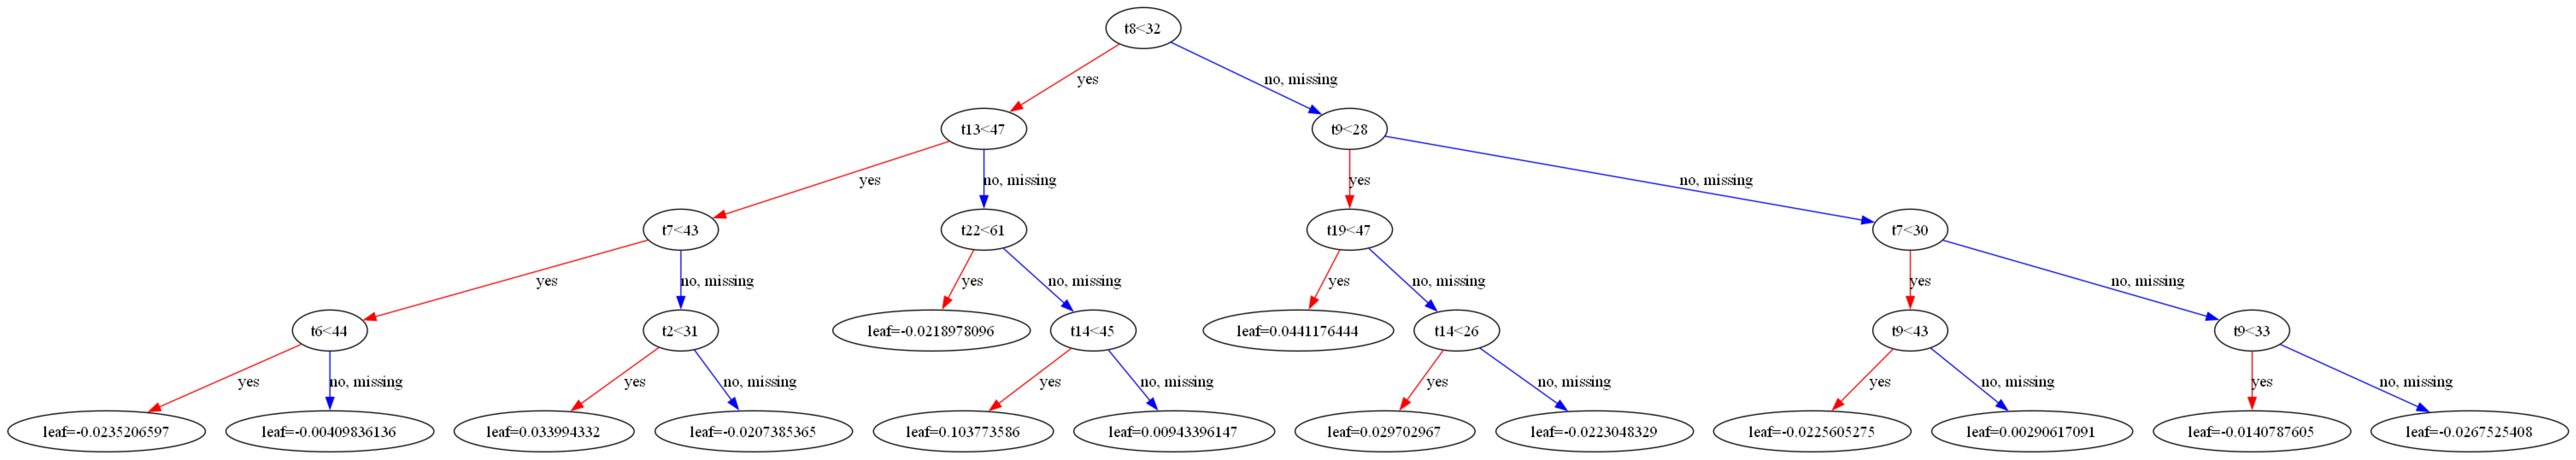

In [126]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

# 설정
rcParams['figure.figsize'] = 100,100
plot_tree(xgb_model, num_trees=5)
plt.show()


In [125]:
from xgboost import DMatrix

# 특정 샘플에 대한 예측 경로 추적
dtest = DMatrix(x_test)  # 테스트 데이터 준비
pred_leaf = xgb_model.predict(dtest, pred_leaf=True)  # 각 트리의 리프 노드 예측 확인

print(pred_leaf)  # 샘플별로 각 트리에서 리프 노드에 도달한 경로 출력


[[ 3. 22. 11. ...  0.  0. 17.]
 [ 5. 22. 25. ...  0.  0. 17.]
 [ 3.  3. 15. ...  0.  0.  3.]
 ...
 [14. 15. 15. ...  0.  0. 12.]
 [13. 15. 15. ...  0.  0.  3.]
 [ 5. 22. 17. ...  0.  0. 11.]]
